In [59]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd

from datetime import datetime

In [60]:
time_suffix = datetime.now().strftime("%y%m%d_%H%M%S")
time_suffix

'210429_234053'

In [61]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [62]:
from numba import njit
@njit
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
 

In [63]:
if False:#True:
    t0 = np.arange(0,10,5e-6)
    tt = 10
    time = []
    for k in range(0, 78 * tt):
        time.append(t0[k])
    for k in range(0, 1000 * tt):
        time.append(t0[k])
    for k in range(0, 1000 * tt):
        time.append(t0[k])
    for k in range(0, 2000 * tt):
        time.append(t0[k])
    for k in range(0, 922 * tt):
        time.append(t0[k])
    np.save('time_5e-6', time)

t_step = np.load('time_1e-5.npy')
len(t_step)

25000

$$ \frac{\partial V_{p}}{\partial t} = \frac{V_{c} - V_{p}}{C_{p}*R_{p}} \\ $$
$$ \frac{\partial V_{m}}{\partial t} = \frac{V_{p} + V_{off} - V_{m}}{C_{m}*R_{s}} - \frac{I_{ion}+I_{leak}}{C_m} \\ $$
$$ \frac{\partial m}{\partial t} = \frac{m_{inf} - m}{\tau_{m}}  \\ $$
$$ \frac{\partial h}{\partial t} = \frac{h_{inf} - h}{\tau_{h}}  \\ $$
$$
I_{m} = C_{m} *\frac{\partial V_{m}}{\partial t} \\
I_{p} = C_{p} *\frac{\partial V_{p}}{\partial t} \\
I_{leak} = g_{leak} * V_{m}
$$

In [64]:
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c
@njit
def initial_state(n, dt, v_c, v_rev, v_p, v_m, v_comp, m_inf, h_inf, m, h, j, I_leak, I_Na, x):
    
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, a0_j, b0_j, delta_j, s_j,tau_j_const,\
    r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h, x_c_comp,x_r_comp, alpha, v_off = x
    
    c_comp = x_c_comp*c_m
    r_comp = x_r_comp*r_m

    
    alpha_m  = a0_m * np.exp( v_m / (s_m))
    beta_m = b0_m * np.exp( v_m / (-delta_m))

    alpha_h  = a0_h * np.exp(v_m / (-s_h))
    beta_h = b0_h * np.exp( v_m / delta_h)

    #if False:
    #    alpha_m  = a0_m * np.exp( v_m / (s_m)) 
    #    beta_m = b0_m * np.exp( v_m / (-delta_m))
        
    #    alpha_h  = a0_h * np.exp(v_m / (s_h)) 
    #    beta_h = b0_h * np.exp( v_m/ (-delta_h))
        
    alpha_j  = a0_j * np.exp( v_m / (s_j)) 
    beta_j = b0_j * np.exp( v_m / (-delta_j))
    v_hold = -80    
    tau_m = 1 / (beta_m + alpha_m)#+0.000037
    tau_h = 1 / (beta_h + alpha_h)#+0.0002       
    tau_j = tau_j_const + 1 / (beta_j + alpha_j) 
    betta = 1/(1-alpha) - 1
    
    
    tau_srp = r_m * c_m * (1 - alpha)
    v_comp = v_c + (v_comp - v_c) * np.exp(-dt / tau_srp)
    v_cp =  v_c + (v_c - v_comp)*betta 
    v_p = v_cp + (v_p - v_cp) * np.exp(-dt / (r_p * c_p))
    v_m = v_m + (v_p + v_off - v_m ) * (dt / (r_m * c_m)) - 1e-9 * (I_Na + I_leak) * dt / c_m 
    
    m = m_inf + (m - m_inf) * np.exp(-dt/tau_m)
    h = h_inf + (h - h_inf) * np.exp(-dt/tau_h)
    j = h_inf + (j - h_inf) * np.exp(-dt/tau_j)
        
    m_inf = 1 / (1 + np.exp((- v_half_m - v_m) / k_m))
    h_inf = 1 / (1 + np.exp((v_half_h + v_m) / k_h))
        
    I_leak = g_leak * v_m
    I_Na = g_max * h * (m**3) * (v_m - v_rev) * j 
    return v_cp, v_p, v_m, v_comp, m_inf, h_inf, m, h, j, I_leak, I_Na

@njit
def calculate_cicle(n, t, v_c, v_rev, x):
    
    g_leak = x[-8]
    m_inf = np.zeros_like(t)
    h_inf = np.zeros_like(t)
    #
    v_cp = np.zeros_like(t)
    v_p = np.zeros_like(t)
    v_m = np.zeros_like(t)
    v_comp = np.zeros_like(t)
        
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    j = np.zeros_like(t)
    
    I_leak = np.zeros_like(t)
    I_Na = np.zeros_like(t)
    
    v_p[0] = -80
    v_m[0] = -80
    v_comp[0] =  - 80
    v_cp[0] =  - 80
    
    m_inf[0] = 0
    h_inf[0] = 1
    
    m[0] = 0
    h[0] = 1
    n_step = len(t)
    
    dt = t[1] - t[0]
    I_leak[0] = g_leak * v_m[0]
    time_ = 25000 
    n_start = 15000
    
    #for k in range(n_start):
    #    v_p[0], v_m[0], v_comp[0], m_inf[0], h_inf[0], m[0], h[0], j[0], I_leak[0], I_Na[0] = \
    #    initial_state(dt, v_c[0], v_rev, v_p[0], v_m[0], v_comp[0], m_inf[0], h_inf[0], m[0], h[0], j[0],
    #                  I_leak[0], I_Na[0], x)
    
    for i in range(1, n_step):
        if (i-1)/time_   == (i-1)//time_ :
            for k in range(n_start):
                v_cp[i-1],v_p[i-1], v_m[i-1],v_comp[i-1],m_inf[i-1], h_inf[i-1], m[i-1], h[i-1], j[i-1], I_leak[i-1], I_Na[i-1] =\
                initial_state(k, dt, v_c[0], v_rev, v_p[i-1], v_m[i-1],v_comp[i-1], m_inf[i-1], h_inf[i-1],
                              m[i-1], h[i-1], j[i-1], I_leak[i-1], I_Na[i-1], x)
                
        v_cp[i], v_p[i], v_m[i],v_comp[i],m_inf[i], h_inf[i], m[i], h[i], j[i], I_leak[i], I_Na[i] =\
        initial_state(i, dt, v_c[i-1], v_rev, v_p[i-1], v_m[i-1],v_comp[i-1], m_inf[i-1], h_inf[i-1],
                      m[i-1], h[i-1], j[i-1], I_leak[i-1], I_Na[i-1], x)

      
    return m_inf[::n], h_inf[::n], v_cp,  v_p, v_m, v_comp, I_leak[::n], I_Na[::n]#tau_m[::n], tau_h[::n], tau_j[::n],



def calculate_I_out(x, *args):#, s0, c, protocol, ...):
    #print(x)
    y = x.copy()
    kwargs = args[-1]
    
    t = kwargs['t']
    dt = t[1] - t[0]
    
    n = int(5e-5/dt)
    
    v_list = kwargs['v_list']
    k_list = kwargs['k_list'] * n
    
    if kwargs.get('log_scale', False):
        y[:-1] = np.exp(y[:-1])
        #y = np.exp(y)
        assert np.all(y[:-1] > 0) 
    
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, a0_j, b0_j, delta_j, s_j,tau_j_const,\
    r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h, x_c_comp, x_r_comp, alpha, v_off = y
    

    count = np.zeros_like(t)
    count[k_list] = 1
    count = np.cumsum(count) 
    
    
    v_c = np.zeros_like(t)
    v_c = v_list[count.astype(int)]

    v_rev = 18
   
    
    I_error = np.zeros(len(t)//n)
    try:
        m_inf, h_inf, v_cp, v_p, v_m, v_comp, I_leak, I_Na = calculate_cicle(n, t, v_c, v_rev, y)
    except ZeroDivisionError:
        I_error+=1e100
        return I_error

    I_c = 1e9 * c_m * (np.diff(v_m) / dt)[::n]
    I_p = 1e9 * c_p * (np.diff(v_p) / dt)[::n]
    I_comp=1e9 * x_c_comp* c_m * (np.diff(v_comp) / dt)[::n]
    
    if len(I_c) != len(I_Na):
        I_c = np.concatenate((I_c,I_c[-1:]))
        I_p = np.concatenate((I_p,I_p[-1:]))
        I_comp = np.concatenate((I_comp,I_comp[-1:]))
    
    tau_z = 5e-4 # 1e-12 * 5e8
    
    I_in = I_c  + I_leak + I_Na + I_p - I_comp
    I_out = np.zeros_like(I_in)

    I_out[0] = I_in[0]
    rush_larsen_easy_numba_helper(I_out, I_in, - dt * n / tau_z)
    #euler_numba_helper(I_out,I_in,(dt / tau_z))  
    
    if kwargs.get('graph', True):
        #plt.plot(V_m_list, label = 'command')
        plt.figure()
        
        plt.plot(v_c, label = 'command')
        #plt.plot(v_comp, label = 'compensated')
        plt.plot(v_cp, label = 'prediction')
        plt.plot(v_p, label = 'pipette', ls = '--')
        plt.plot(v_m, label = 'membrane',ls = '-.')
        plt.legend()
        v_graph = np.arange(-95,35)

        
        plt.figure()
        plt.plot( m_inf, label = 'm_inf')
        plt.plot( h_inf, label = 'h_inf')
        plt.legend()
        
        plt.figure() 
        #tau_m_graph = 1 / (b0_m * np.exp((1-delta_m) * v_graph / (-s_m))
        #                  + a0_m * np.exp( v_m[i-1] / (s_m)) 
        #tau_h_graph = 1 / (b0_h * np.exp((1-delta_h) * v_graph / (-s_h))
        #                  + a0_h * np.exp(-delta_h * v_graph / (-s_h)))
        
        tau_m_graph = 1 / (a0_m * np.exp( v_graph / (s_m))
                          +  b0_m * np.exp( v_graph / (-delta_m)))
        tau_h_graph = 1 / (a0_h * np.exp(v_graph / (-s_h))
                          +  b0_h * np.exp( v_graph / (delta_h)))
        tau_j_graph = tau_j_const + 1 / (a0_j * np.exp(v_graph / (s_j))
                          +  b0_j * np.exp( v_graph / (-delta_j)))
        plt.plot(v_graph, tau_m_graph, label = 'tau_m')
        plt.plot(v_graph, tau_h_graph, label = 'tau_h')
        plt.plot(v_graph, tau_j_graph, label = 'tau_j')
        
        #plt.plot(tau_m, label = 'tau_m')
        #plt.plot(tau_h, label = 'tau_h')
        plt.legend()

        plt.figure()
        plt.plot(I_c, label = 'I_c')
        plt.plot(I_p, label = 'I_p')
        plt.plot(I_leak, label = 'I_leak')
        plt.plot(I_Na, label = 'I_Na',ls = '-.')
        plt.legend()
        

        plt.figure()
        #plt.plot(I_in, label = 'I_in')
        plt.plot(I_out, label = 'I_out')
        plt.legend() 



    return I_out


In [65]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])
t = np.load('../data/time.npy')
t_all = np.concatenate([t for k in range(20)])


In [66]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80,-70,-80, -10, -80])

In [67]:
def log_x(a):
    b = a.copy()
    b[2:10] = np.log(a[2:10])
    b[14:18] = np.log(a[14:18])
    return(b)


In [68]:
%matplotlib inline
%matplotlib notebook
plt.style.use('../styles/general.mplstyle')

<IPython.core.display.Javascript object>


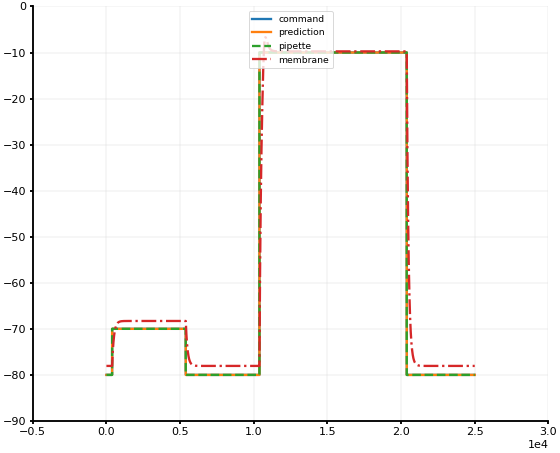

<IPython.core.display.Javascript object>


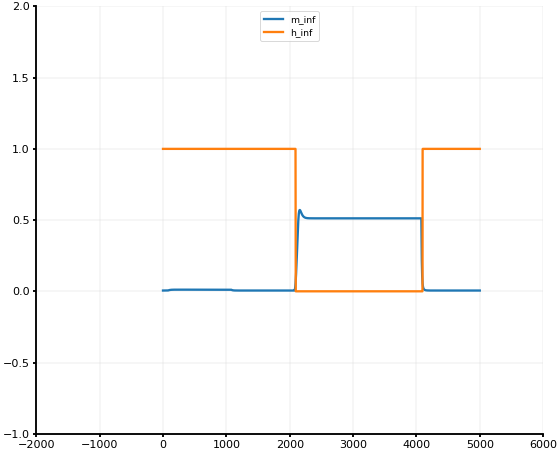

<IPython.core.display.Javascript object>


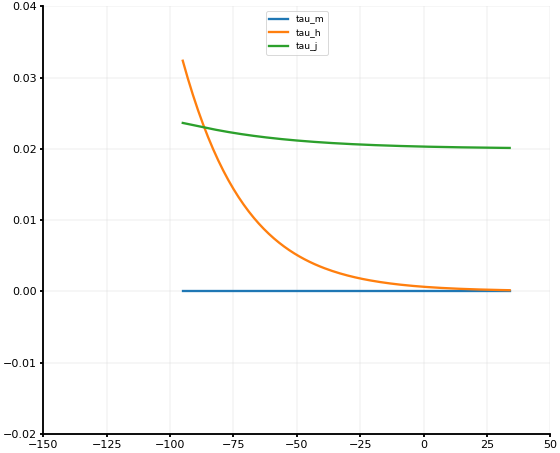

<ipython-input-64-89acc1945039>:199: RuntimeWarning: overflow encountered in exp
  +  b0_m * np.exp( v_graph / (-delta_m)))
<ipython-input-64-89acc1945039>:199: RuntimeWarning: overflow encountered in multiply
  +  b0_m * np.exp( v_graph / (-delta_m)))


<IPython.core.display.Javascript object>


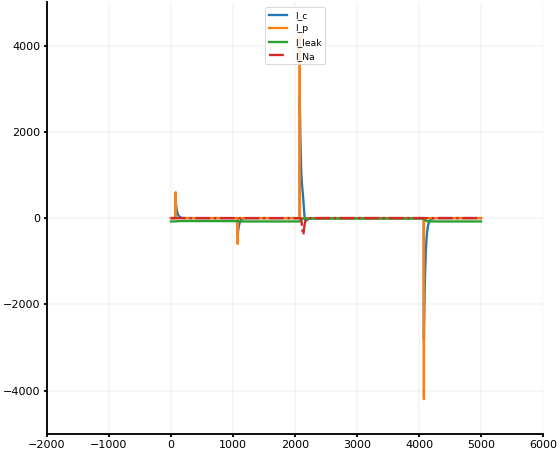

<IPython.core.display.Javascript object>


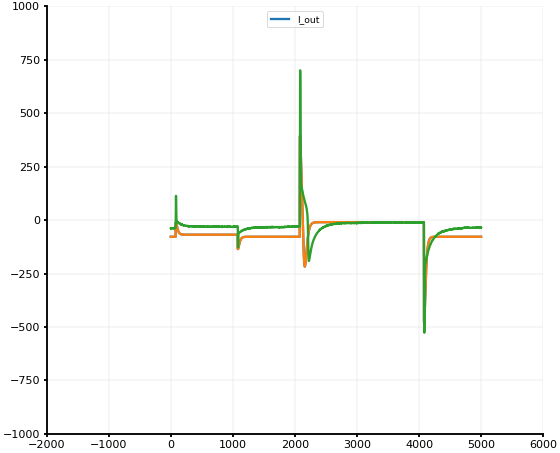

In [69]:
#p0 = np.array([6e-16, 6e-12, 2e3,  1.6e3,   0.9,   60,  1e-1,   4e2,    0.3,     3,    8e8,   5e3,  13,   2e-1, 11, 52,0.2,0.3,10])
#x_true = [6e-15, 12e-12, 5e4,  8e-2,   0.3,   60,  1e-3,   4e2,    0.08,     22,    5e8,   1e6,   5e1,   1e-1]
#p0 = np.array([6e-16, 5e-11, 90e+1,  3.9,8.21,   12.8,    6.3,   1.75e02,    6.72,  21.65,    5e6,   5e5,5e1,   5e-2,20,53,5,0.66, 5])
#             C_p     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak  "v_half_m", "v_half_h", "k_m", "k_h", "v_off"

#from Roman
#p0 = np.array([6e-16, 5e-11, 90e1,  3.9,   8.21,   12.8,    6.3,   1.75e02,    6.72,    21.65,   5e6,   5e4,  5e1,   5e-0,20,53,5,0.66, 0])
p0 = np.array([6.00e-13, 5.00e-11,#C_p , C
               2.40e+10, 6.90e+01, 1.2e-01, 2.86e+03,#a0_m , b0_m , delta_m , s_m 
               1.15e-01, 1.57e+03, 2.4e+01,  4.6e+01,#a0_h , b0_h , delta_h , s_h 
               3.13e+03, 1.13e-04, 8.28e+00, 3.84e+01, 2.00e-02,#a0_j , b0_j , delta_j , s_j , tau_j_const
               2.50e+07, 7.00e+04, 4.27e+02, 1.00e+0,#R , R_p , g_max , g_leak 
               1.04e+01, 4.64e+01, 1.30e+01, 2.80e-01,#v_half_m , v_half_h , k_m, k_h
               8.00e-01, 7.90e-01, 0.10e-03, 0.00e+00])# x_c_comp,x_r-Comp, alpha, v_off



if False:
    p0 = np.array([6.000e-16, 1.200e-11,#C_p , C
               9.454e+03, 1.931e-02, 5.955e+00, 3.477e+01,#a0_m , b0_m , delta_m , s_m 
               6.305e+03, 1.184e-02, 6.285e+00, 2.027e+01,#a0_h , b0_h , delta_h , s_h 
               3.132e+02, 1.132e-04, 8.281e+00, 3.845e+01, 2.038e-03,#a0_j , b0_j , delta_j , s_j , tau_j_const
               5.000e+07, 5.000e+05, 5.000e+02, 5.000e+4, #R , R_p , g_max , g_leak  
               2.000e+01, 5.300e+01, 5.000e+00, 6.600e-01,#v_half_m , v_half_h , k_m, k_h
               5.000e-01])#v_off


#x_true_log = np.log(p0)
x_true_log = np.concatenate((np.log(p0[:-1]),p0[-1:]))
#print(len(x_true_log))

#t = np.load('../data/time.npy')

v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
k_list = k_all#np.array([77, 1077, 2077, 4077]) 
dt = t[1] - t[0]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t_step,
              log_scale = True,
              graph = True)#,
              #sample_weights = sample_weight)

data = calculate_I_out(x_true_log, kwargs)

#print(p0)
#print(data)
#plt.plot(data)
#np.save('data', data)
#plt.plot(np.load('data.npy'))
plt.plot(data)
plt.plot(real_data_small)

In [70]:
#%matplotlib notebook
#plt.plot(v_c, label = 'command_prediction')
#plt.plot(v_p, label = 'pipette', ls = '--')
#plt.plot(v_m, label = 'membrane')
#plt.legend()
#v_graph = np.arange(-95,35)
#plt.show()

In [98]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
    if np.any(np.isinf(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [72]:
%%timeit
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
loss(x_true_log, data, kwargs)

7.24 ms ± 935 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
names =  ["C_f","C",
          "a0_m","b0_m","delta_m","s_m",
          "a0_h","b0_h" ,"delta_h","s_h",
          "a0_j","b0_j" ,"delta_j","s_j","tau_j_const",
          "R"   , "R_f"  , "g_max"  ,"g_leak",
          "v_half_m", "v_half_h", "k_m", "k_h",
          "x_c_comp", "x_r_comp", "v_off" ]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
x0 = x_true_log + 0.23
bounds = np.vstack([x_true_log  - 2, x_true_log + 2]).T#
#bounds = ([1e-18, 1e-13, 1e-10, 1e-10, -1e2,  1e-10, 1e-10, 1e-10, 1e-10,-1e3, 1e5,  1e3,  1e-5, 1e-5,  1e-4,     1e-4,   1e-4,1e-4,-50],
#          [1e-11,  1e-10, 1e8,   1e6,   1,      1e4,   1e8,   1e8,   1,     1e8,   1e15, 1e15, 1e5,  1e5,   100,      100,    1e2, 1e2,50])
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:])),\
                        np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T
#log_bounds = np.vstack([np.log(bounds[0]),np.log(bounds[1])]).T

loss(x0, data, kwargs)

<ipython-input-73-8a26fe52f784>:18: RuntimeWarning: invalid value encountered in log
  log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:])),\
<ipython-input-73-8a26fe52f784>:19: RuntimeWarning: invalid value encountered in log
  np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T


2252.863287696964

In [74]:
%matplotlib inline
plt.style.use('../styles/general.mplstyle')

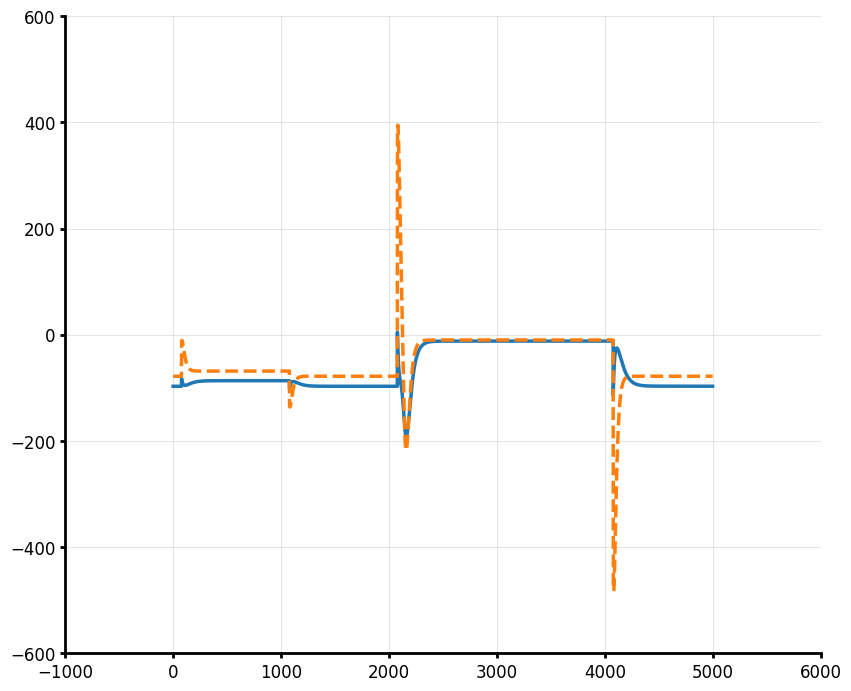

In [75]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [76]:
#%%time
#res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))
#C_p C a0_m b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak  "v_half_m", "v_half_h", "k_m", "k_h", "v_off"
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
res = scop.minimize(loss, x0, bounds = bounds, args=(data, kwargs),method = 'Nelder-Mead',
                    options={ 'adaptive':True, 'maxiter':10000})



/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [77]:
loss(res.x, data, kwargs)

19.983162976338672

In [78]:
print('error in param = ' ,x_true_log - res.x)

error in param =  [-2.73985510e+00 -1.91801093e+00  1.57813163e+02 -1.57520321e+01
 -4.71520436e+00 -3.38114205e+00 -2.15418444e-01 -3.99776865e-01
 -2.40505570e+00 -1.36802208e+01  5.12502347e-01  2.84299937e+00
  2.25248224e+00 -5.23553234e+00  1.55481639e-01  1.54635015e+00
 -4.38602237e+00 -4.36109481e+00  9.35713277e-03 -6.61347059e-01
 -4.85842953e-01  3.31297788e-01 -6.73317737e-02 -2.13160565e-01
 -2.36045734e-01  3.20846536e+01 -4.07687336e-01]


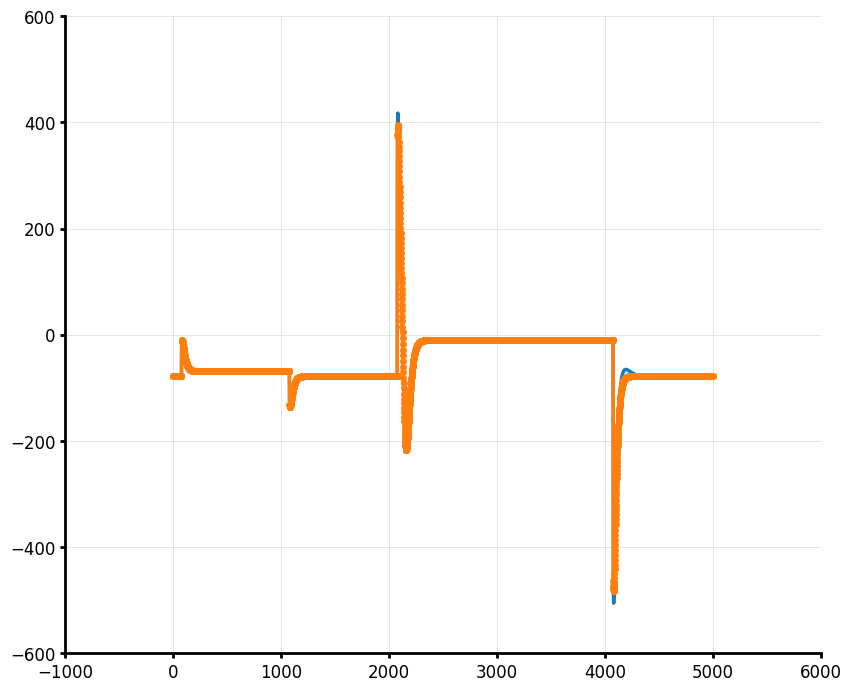

In [79]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '.-')

 ### real_data_minimize


In [80]:
import os
import pickle

In [81]:
def create_backup(*objects):

    folder_name = "../data/backups"
        
    time_suffix = datetime.now().strftime("%y%m%d_%H%M%S")
    
    folder_name = os.path.join(folder_name, time_suffix)
    os.makedirs(folder_name)
    
    backup_filename = os.path.join(folder_name, "backup.pickle")
    with open(backup_filename, 'wb') as f:
        pickle.dump(objects, f)
        
    return time_suffix
        

def recover_backup(time_suffix):
    
    folder_name = "../data/backups"

    folder_name = os.path.join(folder_name, time_suffix)
    
    backup_filename = os.path.join(folder_name, "backup.pickle")
    with open(backup_filename, 'rb') as f:
        objects = pickle.load(f)
        
    return objects

#ts = create_backup(res, calculate_I_out)
#ts

In [82]:
def get_full_trace(a):
    data = pd.read_csv( a ,delimiter= '\t', header=None, skiprows = 11)
    for k in range(1,21):
        print(np.mean(data[k][:77]),np.mean(data[k][4877:]))
#get_full_trace('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf')

In [83]:
def line(x,k,l):
    return k*x+l

In [84]:
def no_drift(data):
    v = 1
    final_data = np.zeros(len(data)*(len(data.columns)-1))
    list_drift = np.concatenate((np.arange(0,77),np.arange(1500,2077))) 
    dif=len(data[0])
    for k in range(1,len(data.columns)):
        x_0 = np.arange(dif)
        x = np.arange((k-1) * dif, k * dif)
        data_drift = data[k][list_drift]
        popt,pcov = scop.curve_fit(line, list_drift,data_drift)
        drift = line(x_0,*popt)[::v]
        final_data[(k-1) * dif : k * dif] = data[k] - drift
        #plt.plot(x[::v], data[k][::v])
        #plt.plot(x[::v], data[k][::v]-drift[::v])
        #plt.plot(x[::v], drift[::v])
    return final_data


In [85]:
def no_drift_single(data):
    v = 1
    final_data = np.zeros(len(data))#*(len(data.columns)-1))
    list_drift = np.concatenate((np.arange(0,77),np.arange(1500,2077))) 
    dif=len(data)
    x_0 = np.arange(dif)
    x = np.arange(0, dif)
    data_drift = data[list_drift]
    popt,pcov = scop.curve_fit(line, list_drift,data_drift)
    drift = line(x_0,*popt)[::v]
    final_data = data - drift
    #plt.plot(x[::v], data[k][::v])
    #plt.plot(x[::v], data[k][::v]-drift[::v])
    #plt.plot(x[::v], drift[::v])
    return final_data


In [86]:
#x_true_log = np.load('one_start_scop_minimize.npy')
sample_weight = np.zeros(5000)
w1 = 1
w2 = 5
w3 = 10
#sample_weight[:]+= 1
if True:
    sample_weight[:70] += w2
    sample_weight[90:500]+= w3
    sample_weight[500:1070] += w2
    sample_weight[1090:1500] += w3
    sample_weight[1500:2070] += w2
    sample_weight[2100:2400] += 30
    sample_weight[2400:4070] += w2
    sample_weight[4090:4500] += w3
    sample_weight[4500:] += w2
#sample_weight[k_list_1[2]+40:k_list_1[2]+900] += 1
#sample

In [87]:
%matplotlib inline
plt.style.use('../styles/general.mplstyle')

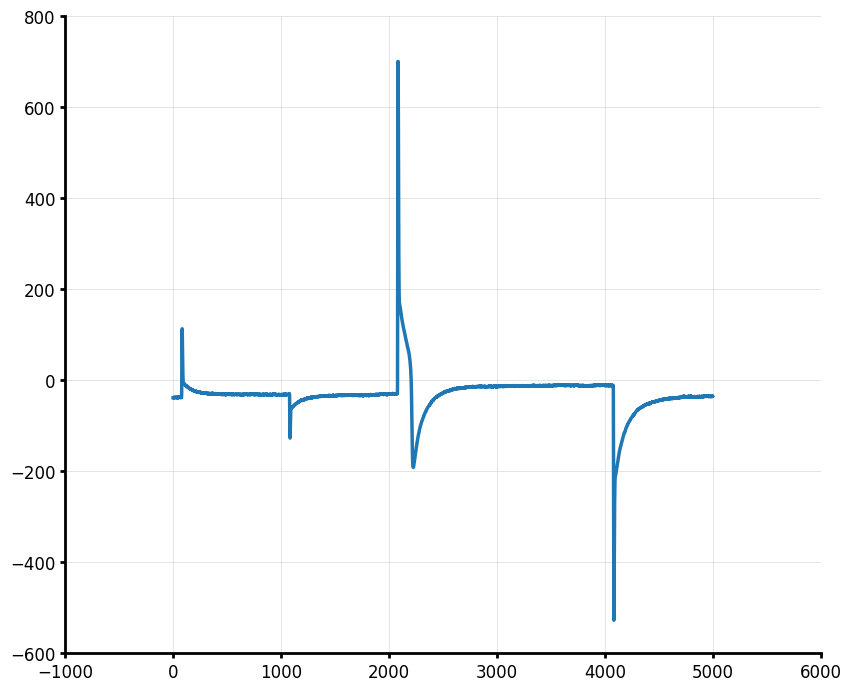

In [105]:
real_data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_21_0007 I-V INa 15.80pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_22_0006 I-V INa 25.16pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_22_0032 I-V INa 21.05pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_23_0007 I-V INa E4031 33.16pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_26_0000 I-V INa 36.60pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_26_0014 I-V INa 15.78pF.atf' ,delimiter= '\t', header=None, skiprows = 11)

real_data_small = real_data[14]

#real_data_all = no_drift(real_data)#np.concatenate([real_data[k] for k in range(1,21)])

real_data_all = np.concatenate([real_data[k] for k in range(1,21)])
sample_weight_all = np.concatenate([sample_weight for k in range(1,21)])


#p0 = np.array([6e-16, 1.6e-10, 90e+1,  3.9,-8.21,   12.8,    6.3,   1.75e02,    6.72,  -21.65,    5e6,   5e5,5e1,   5e-2,20,53,5,0.66, 5])
                   
bounds = ([1e-18, 1e-13,#C_f , C 
           1e-06, 1e-06, 1e-03, 1e-03,# a0_m , b0_m , delta_m , s_m 
           1e-06, 1e-06, 1e-03, 1e-03,#a0_h , b0_h , delta_h , s_h
           1e-06, 1e-06, 1e-03, 1e-03, 1e-8,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+05, 1e+03, 1e-05, 1e-05,#R , R_f , g_max , g_leak
           1e-04, 1e-04, 1e-04, 1e-04,#v_half_m , v_half_h , k_m , k_h
           1e-02, 1e-02, 1e-04, -5e+01],# x_c_comp,x_r-Comp alpha v_off
          
          
          [1e-10, 1e-10,#C_f , C 
           1e+06, 1e+06, 1e+03, 1e+03,# a0_m , b0_m , delta_m , s_m 
           1e+06, 1e+06, 1e+03, 1e+03,#a0_h , b0_h , delta_h , s_h
           1e+06, 1e+06, 1e+03, 1e+03, 1e+06,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+10, 1e+12, 1e+05, 1e+05, #R , R_f , g_max , g_leak
           1e+02, 1e+02, 1e+02, 1e+02,#v_half_m , v_half_h , k_m , k_h
           1e+01, 1e+01, 1e+04, 5e+01])# x_c_comp,x_r-Comp alpha v_off
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:]))
                        , np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T
kwargs_for_count = dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = False,
              sample_weight = sample_weight_all)
plt.plot(real_data_small)

In [90]:
#res = scop.minimize(loss, p0, bounds=log_bounds, args=(real_data_all, kwargs_for_count),method = 'Nelder-Mead',
#               options={ 'adaptive':True})

x = x_true_log

for k in range(5):
    res = scop.minimize(loss, x, bounds=log_bounds, args=(real_data_all, kwargs_for_count),method = 'Nelder-Mead',\
                    options={ 'adaptive':True, 'maxiter':1000})
    print('loop ',k ,': res.x = ', res.x,';\n          loss = ', loss(res.x, real_data_all, kwargs_for_count))
    x = res.x
#create_backup(res, calculate_I_out, kwargs, real_data_all, sample_weight_all)

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


loop  0 : res.x =  [-2.94135378e+01 -2.34464071e+01  2.58053824e+01  4.46929463e+00
 -2.11858001e+00  8.33747270e+00 -1.95733760e+00  7.70536720e+00
  2.52916709e+00  3.55598561e+00  8.28235191e+00 -9.48422901e+00
  2.21176682e+00  3.69127726e+00 -3.28765978e+00  1.78888655e+01
  1.17923934e+01  6.13039659e+00 -8.02121399e-04  2.34136321e+00
  3.59964104e+00  2.63503732e+00 -1.30238927e+00 -2.87369986e-01
 -2.33984682e-01 -9.46626530e+00 -2.37161345e-04] ;
          loss =  1333.2416282062768


/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


loop  1 : res.x =  [-3.31346864e+01 -2.40360135e+01  2.47292408e+01  2.99815344e+00
 -1.53787396e+00  8.34279493e+00 -1.67335015e+00  9.56563268e+00
  1.85332595e+00  1.73538467e+00  8.42767487e+00 -1.08980832e+01
  2.83303895e+00  2.72785779e+00 -3.29078737e+00  1.88863041e+01
  1.12352177e+01  6.42950972e+00 -7.72866620e-04  2.89744947e+00
  3.53887907e+00  2.11435700e+00 -8.24309609e-01 -7.67452092e-01
 -2.30533121e-01 -1.06557968e+01 -1.93179336e-04] ;
          loss =  847.8542768237197


/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


loop  2 : res.x =  [-2.61105329e+01 -2.42155872e+01  1.48080897e+01  2.48363826e+00
 -1.10847667e+00  7.08123642e+00 -1.71027642e+00  5.51304945e+00
  1.70116611e+00  1.93798033e+00  1.19975702e+01 -1.04997365e+01
  2.37975300e+00  3.64652638e+00 -3.87304448e+00  1.94496593e+01
  9.63649082e+00  7.32628416e+00 -8.55592416e-04  2.90386433e+00
  3.89546851e+00  2.02619402e+00 -1.00991082e+00 -1.76143653e+00
 -1.66406131e-01 -7.26578448e+00 -1.81943319e-04] ;
          loss =  638.0954776391198


/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


loop  3 : res.x =  [-2.60428075e+01 -2.43439137e+01  1.43718821e+01  2.35620526e+00
 -1.10863015e+00  6.17369690e+00 -1.62291355e+00  5.14465269e+00
  2.18369510e+00  1.92942646e+00  1.14033602e+01 -1.11025495e+01
  2.33026282e+00  3.66999629e+00 -3.92396802e+00  1.96114103e+01
  8.35136812e+00  7.74000601e+00 -8.75250403e-04  2.89051939e+00
  3.90545313e+00  1.90470741e+00 -1.03551083e+00 -2.21961512e+00
 -1.61893898e-01 -6.69449393e+00 -1.85570700e-04] ;
          loss =  597.8899026243108


/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


loop  4 : res.x =  [-2.60167388e+01 -2.43502064e+01  1.36239852e+01  2.27395334e+00
 -1.06567289e+00  6.11834100e+00 -1.66852299e+00  5.45074636e+00
  2.47693794e+00  1.92426495e+00  1.16767596e+01 -1.10824874e+01
  2.26830636e+00  3.48814943e+00 -3.87210584e+00  1.96462690e+01
  8.03559847e+00  7.92778698e+00 -1.00712455e-03  2.89249335e+00
  3.92415769e+00  1.88155291e+00 -1.01425413e+00 -2.25761684e+00
 -1.61722717e-01 -6.60444799e+00 -1.72719267e-04] ;
          loss =  585.165084565204


In [91]:
#np.save("res_maxiter_5000",res.x)
#np.save('maxiter_5000_best_fit',calculate_I_out(res.x, kwargs_for_count))
#create_backup(res, calculate_I_out, kwargs, real_data_all, sample_weight_all)

In [92]:
%matplotlib notebook

<IPython.core.display.Javascript object>


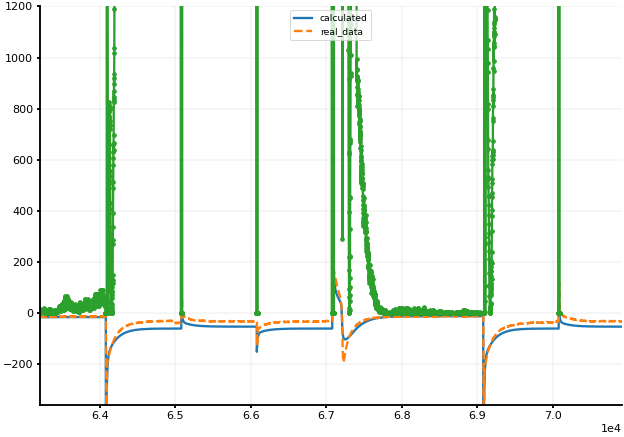

In [93]:
kwargs= dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = True,
              sample_weight = sample_weight_all)
plt.plot(calculate_I_out(res.x, kwargs_for_count), label = 'calculated')
plt.plot(real_data_all,'--', label = 'real_data')

plt.legend()


In [94]:
x = calculate_I_out(res.x, kwargs_for_count) - real_data_all
x **= 2
x *= sample_weight_all
plt.plot(x, '.-', label = 'calculated')
#lt.xlim(2050,2200)

In [95]:
np.sqrt(x[x <= 0.25e5].mean())

55.65792807000682

In [96]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False,
              sample_weight = sample_weight)
plt.plot(real_data_small)
plt.plot(calculate_I_out(res.x, kwargs))

In [97]:
%matplotlib inline

plt.style.use('../styles/general.mplstyle')

<IPython.core.display.Javascript object>


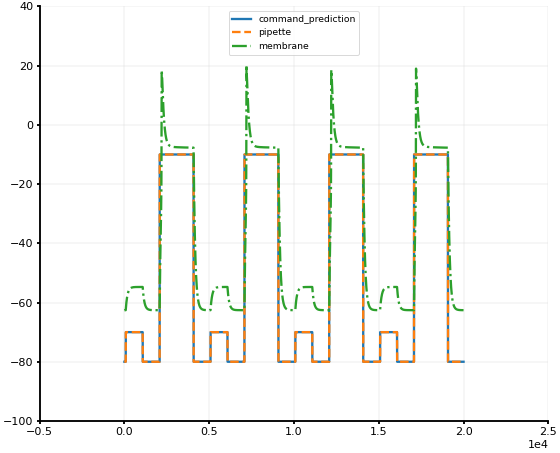

<IPython.core.display.Javascript object>


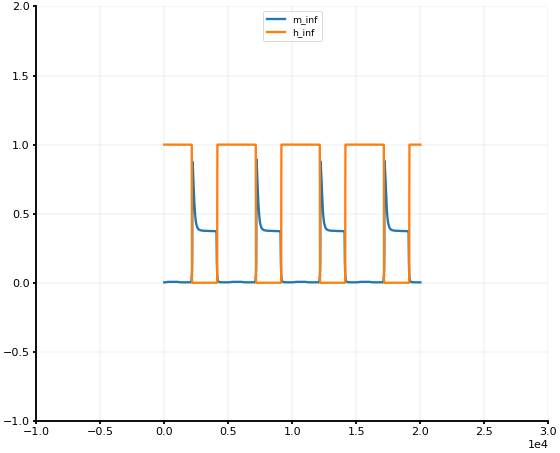

<IPython.core.display.Javascript object>


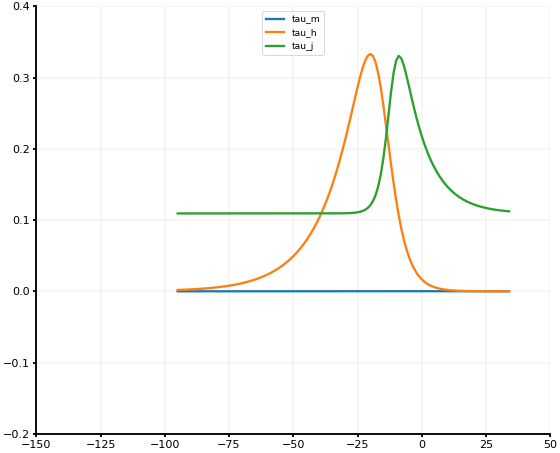

<IPython.core.display.Javascript object>


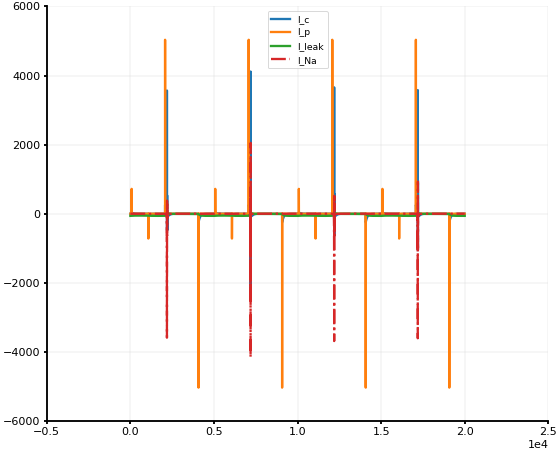

<IPython.core.display.Javascript object>


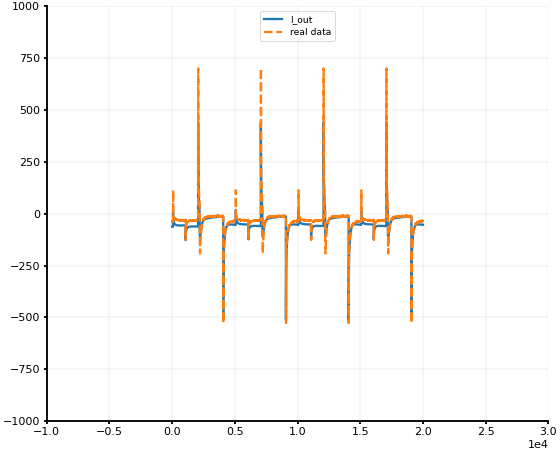

In [78]:
real_data_small = np.concatenate([real_data[14] for k in range(4)])
t_2 = np.concatenate([t for k in range(4)])
#v_2 = np.concatenate([v_list_1 for k in range(4)])
v_2 = np.concatenate([np.array([-80,-70,-80, -10]) for k in range(4)])
k_2 = np.concatenate([k_list_1+5000*k for k in range(4)])
v_2 = np.concatenate([v_2,[-80]])
kwargs = dict(v_list = v_2,
              k_list = k_2,
              t = t_2,
              log_scale = True,
              graph = True)#,
              #sample_weight = sample_weight)
calculate_I_out(res.x, kwargs)
plt.plot(real_data_small, '--', label = 'real data')
plt.legend()

In [ ]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

### differential_evolution

In [ ]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=log_bounds,
                                  args=(real_data_all, kwargs_for_count),
                                  maxiter=10, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1,
                                  seed=42,
                                  )

In [39]:
loss(res.x, real_data_small, kwargs_for_count)

ValueError: Found input variables with inconsistent numbers of samples: [20000, 100000]

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')
#plt.xlim(0, 1000)

### dual_annealing

In [ ]:
%%time
#res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs_for_count), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')